In [ ]:
!pip install xlrd==1.2.0
!pip install folium

In [1]:
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import folium
import json
import requests
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

In [3]:
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_name = font_manager.FontProperties(fname="/Windows/Fonts/gulim.ttc").get_name()
rc('font', family=font_name)

# 데이터 불러오기
## 데이터 파일 불러오기

사용한 데이터
1) 소음민원(2010-2018)   
2) 응급실(2020), 의료기관(2010-2019)   
3) 안전비상벨(2020), CCTV(2018)   
4) 임대주택현황 (2017-2019)   
5) 서울 인구 = 1인가구(연령별)(2015-2019),연령별구별(2014-2019),연령별구별(2020)

In [4]:
import os
path_dir = './1인가구데이터셋'
file_list = os.listdir(path_dir)
file_list_csv = [file for file in file_list if file.endswith(".csv")]
file_list_txt = [file for file in file_list if file.endswith(".txt")]
file_list_xlsx = [file for file in file_list if file.endswith(".xlsx")]

In [5]:
print(file_list_csv)
print(file_list_txt)
print(file_list_xlsx)

['서울시 자치구 목적별 CCTV 설치 현황.csv', '서울주택도시공사_자치구별 임대주택 현황_2019.csv', '서울특별시 응급실 위치 정보.csv', '자치구별 임대주택 현황(2017).csv', '자치구별 임대주택 현황(2018).csv']
['서울시 소음진동민원 현황 통계(2010-2018).txt', '서울시 의료기관 (구별) 통계(2010-2019).txt']
['안전비상벨위치정보.xlsx']


In [6]:
# csv file
data_cctv = pd.read_csv(path_dir+'/'+file_list_csv[0], encoding = "CP949", engine='python') # cctv
data_home2019 = pd.read_csv(path_dir+'/'+file_list_csv[1], encoding = "CP949", engine='python') # 임대주택 현황2019
data_emergency = pd.read_csv(path_dir+'/'+file_list_csv[2], encoding = "CP949", engine='python') # 응급실
data_home2017 = pd.read_csv(path_dir+'/'+file_list_csv[3], encoding = "CP949", engine='python') # 임대주택 현황2017
data_home2018 = pd.read_csv(path_dir+'/'+file_list_csv[4], encoding = "CP949", engine='python') # 임대주택 현황2018

# txt file
data_noise = pd.read_csv(path_dir+'/'+file_list_txt[0], sep = "\t", encoding="utf-8", header=[0,1]) # 소음
data_hospital = pd.read_csv(path_dir+'/'+file_list_txt[1], sep = "\t", encoding="utf-8", header=[0,1]) # 의료기관

In [7]:
# xlsx file
wb = load_workbook(filename = path_dir+'/'+file_list_xlsx[0])
sheet_name = wb.get_sheet_names()[0]
ws = wb[sheet_name]
data_bell = pd.DataFrame(ws.values)
header = data_bell.iloc[0]
data_bell = data_bell[1:]
data_bell.rename(columns=header, inplace=True) # 안전비상벨

In [8]:
path_dir = './1인가구데이터셋/인구'
file_list_p = os.listdir(path_dir)
file_list_p_txt = [file for file in file_list_p if file.endswith(".txt")]
file_list_p_xlsx = [file for file in file_list_p if file.endswith(".xlsx")]
print(file_list_p_txt)
print(file_list_p_xlsx)

['서울시 1인가구(거처종류별) 통계.txt', '서울시 1인가구(연령별) 통계(2010-2019).txt', '서울시 주민등록인구 (구별) 통계(2010-2019).txt', '서울시 주민등록인구 (연령별구별) 통계(2014-2019).txt']
['서울시 주민등록인구 (연령별구별) 2020.xlsx']


In [9]:
# 인구 데이터
data_p_1 = pd.read_csv(path_dir+'/'+file_list_p_txt[1], sep = "\t", encoding="utf-8", header=[0]) # 1인가구
data_p_seoul = pd.read_csv(path_dir+'/'+file_list_p_txt[2], sep = "\t", encoding="utf-8", header=[0]) # 서울 인구(구별)
data_p_seoul2 = pd.read_csv(path_dir+'/'+file_list_p_txt[3], sep = "\t", encoding="utf-8", header=[0]) # 서울 인구(연령별구별)
data_p_seoul3 = pd.read_excel(path_dir+'/'+file_list_p_xlsx[0], sep = "\t", encoding="utf-8", header=[0]) # 서울 인구(연령별구별) 2020

In [10]:
자치구 = ['중랑구','중구','종로구','은평구','용산구','영등포구','양천구','송파구','성북구','성동구','서초구','서대문구','마포구','동작구','동대문구',
 '도봉구','노원구','금천구','구로구','광진구','관악구','강서구','강북구','강동구','강남구']

## 지도 불러오기

In [11]:
# vworld 시군구 API
url = "http://api.vworld.kr/req/data?service=data&request=GetFeature&data=LT_C_ADSIGG_INFO&key=[key]&domain=[domain]&attrFilter=full_nm:like:서울&size=1000"
res = requests.get(url)
gis = res.json()

In [12]:
gu = gis['response']['result']['featureCollection']

In [13]:
folium.Map(location=[37.5502,126.982], zoom_start=10.5, tiles='cartodbpositron',scrollWheelZoom=False)

# 임대주택현황

In [14]:
data_home2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   구별          26 non-null     object
 1   영구          26 non-null     int64 
 2    공공         26 non-null     int64 
 3   국민          26 non-null     int64 
 4   장기전세        26 non-null     int64 
 5   주거환경        26 non-null     int64 
 6   외국인         26 non-null     int64 
 7   행복주택        26 non-null     int64 
 8   재개발         26 non-null     int64 
 9   다가구         26 non-null     int64 
 10  전세임대        26 non-null     int64 
 11  장기안심        26 non-null     int64 
 12  매입원룸        26 non-null     int64 
 13  희망하우징(건설형)  26 non-null     int64 
 14  기타임대        26 non-null     int64 
 15  기타임대.1      26 non-null     int64 
dtypes: int64(15), object(1)
memory usage: 3.4+ KB


In [15]:
data_home2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   구별          26 non-null     object 
 1   영구          26 non-null     int64  
 2    공공         26 non-null     int64  
 3   국민          26 non-null     int64  
 4   장기전세        26 non-null     int64  
 5   주거환경        26 non-null     int64  
 6   외국인         26 non-null     int64  
 7   행복주택        26 non-null     int64  
 8   재개발         26 non-null     int64  
 9   매입다가구       26 non-null     int64  
 10  전세임대        26 non-null     int64  
 11  장기안심        26 non-null     int64  
 12  매입원룸        25 non-null     float64
 13  희망하우징(건설형)  26 non-null     int64  
 14  기타임대        26 non-null     int64  
 15  기타임대.1      26 non-null     int64  
dtypes: float64(1), int64(14), object(1)
memory usage: 3.4+ KB


In [16]:
data_home2018

구별    영구   공공     국민  장기전세  주거환경  외국인  행복주택   재개발  매입다가구  전세임대  장기안심  \
0     강남구    4271  1230  1435  2135     0    0     0     0     65   220    99   
1     강동구       0     0  3211  3996     0    0   346   575    956   555   222   
2     강북구       0     0     0    18     0    0    35  3711    998   584   190   
3     강서구    7441  2870  3985  4233     0    0    30     0    715   791   327   
4     관악구       0     0     0     2   330    0     0  5386    210   562   268   
5      광진구      0     0     0    45     0    0     0    27    459   567   246   
6     구로구       0     0  2085  2431     0    0  1019   805    656   518   158   
7     금천구       0     0     0   192   105    0     0  1852    432   403   107   
8     노원구    6196  5492   687   200     0    0    48  2831    309   551   266   
9     도봉구       0     0     0     0   779    0     0    50   1307   644   188   
10   동대문구       0     0     0    43     0    0   114  6129    671   338   145   
11    동작구       0     0     0   238   218    0    58  4143    119   445   199   
12    마포구    1807   820  1748  1298   178  175     0  3898    122   301   148   
13    서대문구      0     0     0    56     0    0   130  5009    565   297   119   
14    서초구     146     0  1814  4074     0    6   481    81     75   217   119   
15    성동구       0     0   400   108     0    0   199  8214     87   349   111   
16    성북구       0     0   254    61     0    0   125  6500   1080   502   200   
17    송파구       0  1258  4611  2585    25    0   276   153    659   626   450   
18    양천구       0  4706   968  1781     0    0     0  2616    643   565   219   
19   영등포구       0   195     0    48   175    0    48  1047     91   260   105   
20    용산구       0     0     0     0     0    0     0  1065     11   377   112   
21    은평구       0     0  1804  4023   153    0   106  2238    996   842   317   
22    종로구       0     0     0     0     0    0   188   858     82   167    50   
23     중구       0     0     0     0     0    0    36  4476     10   101    28   
24    중랑구    2811   861  1166  1957     0    0   339    24    389   633   241   
25    의정부시      0     0   313   315     0    0     0     0      0     0     0   

     매입원룸  희망하우징(건설형)  기타임대  기타임대.1  
0    62.0           0    30      30  
1   344.0           0    76      76  
2   108.0           0     0       0  
3   125.0          26   114     114  
4    24.0           0     0       0  
5   180.0           0     0       0  
6   396.0           0    96      96  
7   214.0           0    10      10  
8   211.0          57    15      15  
9    67.0           0     8       8  
10  275.0           0     6       6  
11  123.0           0    30      20  
12  165.0          30     0       0  
13  479.0           0     0       0  
14    0.0           0   115     115  
15   38.0           0     0       0  
16  408.0          54    11      11  
17  133.0           0    31      31  
18  211.0           0    92      92  
19   98.0           0     0       0  
20    0.0           0     0       0  
21  101.0          41     5       5  
22    0.0           0     0       0  
23    0.0           0    29      29  
24  212.0           0   222     222  
25    NaN           0     0       0

In [17]:
# 자치구칼럼명 통일
data_home2019.rename(columns={'구별': '자치구'}, inplace=True)
data_home2019.head(3)

자치구    영구   공공     국민  장기전세  주거환경  외국인  행복주택   재개발   다가구  전세임대  장기안심  \
0   강남구    4271  1230  1450  2120     0    0   247     0    65   218   131   
1   강동구       0     0  3294  3913     0    0   642   575  1097   685   276   
2   강북구       0     0     0    18     0    0   123  3711  1016   689   209   

   매입원룸  희망하우징(건설형)  기타임대  기타임대.1  
0    62           0    30      30  
1   477           0    76      76  
2   118           0     0       0

In [18]:
data_home2018.rename(columns={'구별': '자치구'}, inplace=True)
data_home2017.rename(columns={'구별': '자치구'}, inplace=True)

In [19]:
# 합계 칼럼 추가
col_list = ['영구', ' 공공 ', '국민', '장기전세', '주거환경', '외국인', '행복주택', '재개발', '다가구', '전세임대', '장기안심', '매입원룸', '희망하우징(건설형)', '기타임대']
data_home2019['합계'] = data_home2019[col_list].sum(axis=1)

In [20]:
# 2018, 2017 데이터는 다가구->매입다가구 (컬럼명 상이)
col_list = ['영구', ' 공공 ', '국민', '장기전세', '주거환경', '외국인', '행복주택', '재개발', '매입다가구', '전세임대', '장기안심', '매입원룸', '희망하우징(건설형)', '기타임대']
data_home2018['합계'] = data_home2018[col_list].sum(axis=1)
data_home2017['합계'] = data_home2017[col_list].sum(axis=1)

In [21]:
# 임대주택 현황 데이터 통합
data_home= pd.DataFrame(data_home2019['자치구'])
data_home['2019'] = data_home2019['합계']
data_home['2018'] = data_home2018['합계']
data_home['2017'] = data_home2017['합계']
data_home

자치구   2019     2018   2017
0     강남구     9824   9547.0   9539
1     강동구    11035  10281.0   9973
2     강북구     5884   5644.0   5531
3     강서구    20962  20657.0  20438
4     관악구     7178   6782.0   6681
5      광진구    1654   1524.0   1245
6     구로구    10193   8164.0   7129
7     금천구     3962   3315.0   2969
8     노원구    17106  16863.0  16708
9     도봉구     3239   3043.0   2839
10   동대문구     8341   7721.0   6994
11    동작구     5668   5573.0   5077
12    마포구    10879  10690.0  10507
13    서대문구    7036   6655.0   6311
14    서초구     7336   7128.0   6757
15    성동구     9525   9506.0   8968
16    성북구    10433   9195.0   8713
17    송파구    12455  10807.0   9949
18    양천구    12425  11801.0  11624
19   영등포구     2242   2067.0   2022
20    용산구     1720   1565.0   1502
21    은평구    12211  10626.0   9957
22    종로구     1388   1345.0   1296
23     중구     4705   4680.0   4668
24    중랑구     9250   8855.0   8434
25    의정부시     628    628.0    628

In [22]:
# 25행 의정부시 삭제
data_home = data_home.drop([25])
data_home

자치구   2019     2018   2017
0     강남구     9824   9547.0   9539
1     강동구    11035  10281.0   9973
2     강북구     5884   5644.0   5531
3     강서구    20962  20657.0  20438
4     관악구     7178   6782.0   6681
5      광진구    1654   1524.0   1245
6     구로구    10193   8164.0   7129
7     금천구     3962   3315.0   2969
8     노원구    17106  16863.0  16708
9     도봉구     3239   3043.0   2839
10   동대문구     8341   7721.0   6994
11    동작구     5668   5573.0   5077
12    마포구    10879  10690.0  10507
13    서대문구    7036   6655.0   6311
14    서초구     7336   7128.0   6757
15    성동구     9525   9506.0   8968
16    성북구    10433   9195.0   8713
17    송파구    12455  10807.0   9949
18    양천구    12425  11801.0  11624
19   영등포구     2242   2067.0   2022
20    용산구     1720   1565.0   1502
21    은평구    12211  10626.0   9957
22    종로구     1388   1345.0   1296
23     중구     4705   4680.0   4668
24    중랑구     9250   8855.0   8434

In [23]:
# 띄어쓰기 지우기
data_home['자치구'] = data_home['자치구'].replace(' ','',regex=True)

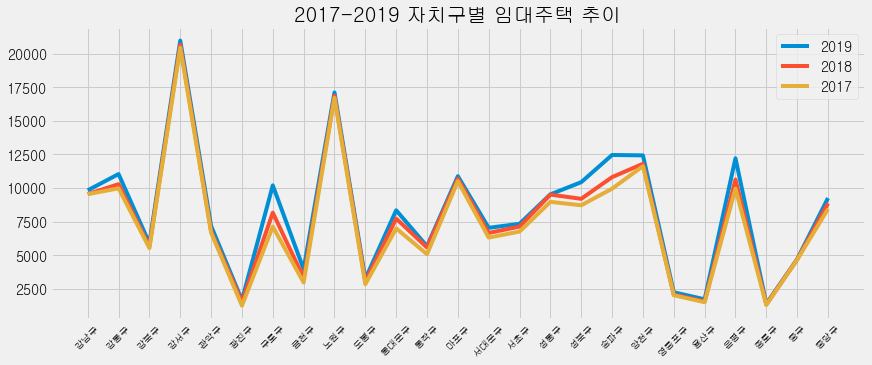

In [24]:
plt.figure(figsize=(13,5))
plt.title('2017-2019 자치구별 임대주택 추이')
plt.xticks(rotation=45, size=10)
plt.plot(data_home['자치구'], data_home['2019'], label='2019')
plt.plot(data_home['자치구'], data_home['2018'], label='2018')
plt.plot(data_home['자치구'], data_home['2017'], label='2017')
plt.legend()
plt.show()

연도별 자치구의 임대주택 현황은 비슷한 추이를 보여준다. 구로구, 성북구, 송파구 등에 2019년도 증가 외에는 큰 차이가 없음   
큰 차이가 없기에 가장 최신 데이터인 2019년 데이터로만 지도 시각화 진행

In [25]:
home_map = folium.Map(location=[37.5502,126.982], zoom_start=10.5, tiles='cartodbpositron',scrollWheelZoom=False)
choropleth = folium.Choropleth(geo_data=gu, key_on='properties.sig_kor_nm', data=data_home, columns=['자치구','2019'],legend_name='2019 서울시 임대주택 현황').add_to(home_map)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['sig_kor_nm']))
home_map

# 서울 인구 데이터

## 서울 1인가구

In [26]:
# 1인가구 데이터는 2015~2019만 사용 (2010 제외)
data_p_1 = data_p_1[data_p_1['기간']!=2010]
data_p_1 = data_p_1.reset_index().drop(columns='index')

In [27]:
# 자치구 칼럼명 통일
data_p_1.rename(columns={'구분': '자치구'}, inplace=True)

In [28]:
data_p_1.iloc[:,3:] = data_p_1.iloc[:,3:].replace(',','',regex=True).astype(int)

In [29]:
data_p_1.head(3)

기간 자치구  성별       합계  20세미만  20~24세  25~29세  30~34세  35~39세  40~44세  \
0  2015  합계   계  1115744  13721   93068  165410  157667  105540   94750   
1  2015  합계  남자   544059   5604   37155   84013   89993   60969   56732   
2  2015  합계  여자   571685   8117   55913   81397   67674   44571   38018   

   45~49세  50~54세  55~59세  60~64세  65~69세  70~74세  75~79세  80~84세  85세이상  
0   82138   77390   77679   62250   56374   50095   39946   24674  15042  
1   50215   45825   38696   26040   19525   13667    8777    4257   2591  
2   31923   31565   38983   36210   36849   36428   31169   20417  12451

연령대 기준 = 20-39:청년층, 40-64:중장년층, 65세 이상:노년층

In [30]:
# 연령대별 데이터 통합
col_young = ['20~24세','25~29세','30~34세','35~39세']
col_middle = ['40~44세','45~49세','50~54세','55~59세','60~64세']
col_old = ['65~69세','70~74세','75~79세','80~84세','85세이상']
data_p_1['청년층'] = data_p_1[col_young].sum(axis=1)
data_p_1.drop(col_young, axis=1, inplace=True)
data_p_1['중장년층'] = data_p_1[col_middle].sum(axis=1)
data_p_1.drop(col_middle, axis=1, inplace=True)
data_p_1['노년층'] = data_p_1[col_old].sum(axis=1)
data_p_1.drop(col_old, axis=1, inplace=True)
data_p_1

기간  자치구  성별       합계  20세미만     청년층    중장년층     노년층
0    2015   합계   계  1115744  13721  521685  394207  186131
1    2015   합계  남자   544059   5604  272130  217508   48817
2    2015   합계  여자   571685   8117  249555  176699  137314
3    2015  종로구   계    22776    396   10582    7816    3982
4    2015  종로구  남자    11608    134    5614    4558    1302
..    ...  ...  ..      ...    ...     ...     ...     ...
385  2019  송파구  남자    31036    136   15650   12166    3084
386  2019  송파구  여자    37825    146   17631   12004    8044
387  2019  강동구   계    45188    157   17219   18289    9523
388  2019  강동구  남자    21674     68    8612   10047    2947
389  2019  강동구  여자    23514     89    8607    8242    6576

[390 rows x 8 columns]

In [31]:
# 연도별 1인가구 합계
data_p_1_sum = data_p_1[(data_p_1['성별']=='계') & (data_p_1['자치구']=='합계')]
data_p_1_sum

기간 자치구 성별       합계  20세미만     청년층    중장년층     노년층
0    2015  합계  계  1115744  13721  521685  394207  186131
78   2016  합계  계  1138860  14937  530082  397385  196456
156  2017  합계  계  1180540  14190  548761  408349  209240
234  2018  합계  계  1229421  14487  578491  415455  220988
312  2019  합계  계  1299787  12806  621619  427274  238088

In [32]:
data_p_1_sum = data_p_1_sum.reset_index().drop(columns='index')

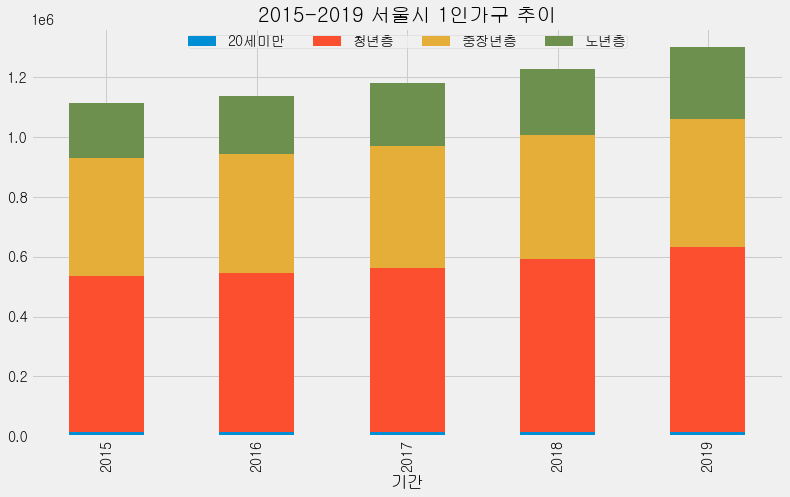

In [33]:
# 2015-2019 1인가구 연령층별 비중
data_p_1_sum_n = data_p_1_sum.iloc[:,4:]
data_p_1_sum_n = data_p_1_sum_n.set_index(data_p_1_sum['기간'])
data_p_1_sum_n.plot(kind='bar', stacked=True, title='2015-2019 서울시 1인가구 추이', figsize=(12,7))
plt.legend(ncol=4, loc='upper center',borderpad=0)
plt.show()

1인가구의 수는 매년 증가하고 있으며, 청년층과 중장년층의 비중이 가장 높다.

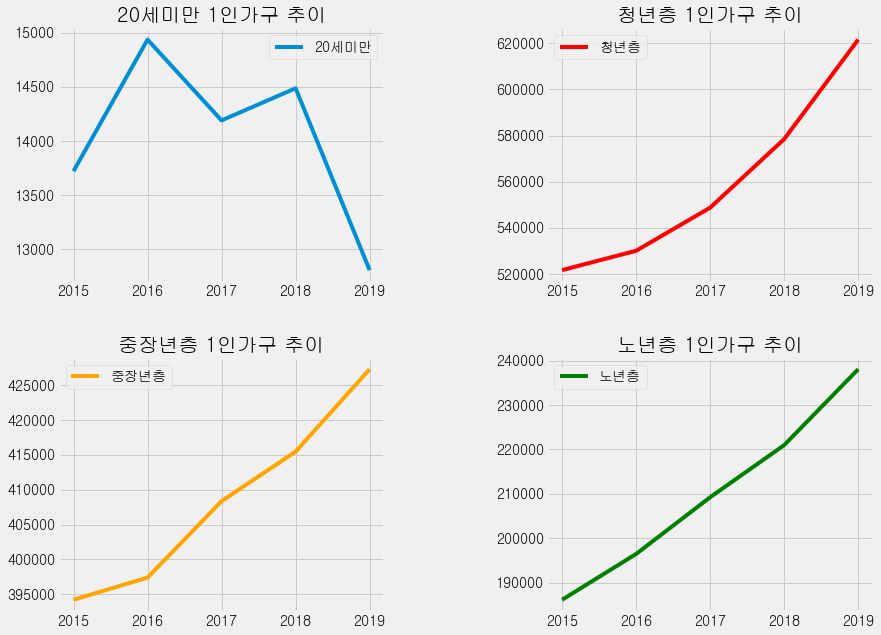

In [34]:
# 2015-2019 연령층별 1인가구 추이
plt.figure(figsize=(13,10))
plt.subplot(221)
plt.plot(data_p_1_sum['기간'], data_p_1_sum['20세미만'], label='20세미만')
plt.xticks(data_p_1_sum['기간'],['2015','2016','2017','2018','2019'])
plt.title('20세미만 1인가구 추이')
plt.legend()

plt.subplot(222)
plt.plot(data_p_1_sum['기간'], data_p_1_sum['청년층'], label='청년층', color='red')
plt.xticks(data_p_1_sum['기간'],['2015','2016','2017','2018','2019'])
plt.title('청년층 1인가구 추이')
plt.legend()

plt.subplot(223)
plt.plot(data_p_1_sum['기간'], data_p_1_sum['중장년층'], label='중장년층', color='orange')
plt.xticks(data_p_1_sum['기간'],['2015','2016','2017','2018','2019'])
plt.title('중장년층 1인가구 추이')
plt.legend()

plt.subplot(224)
plt.plot(data_p_1_sum['기간'], data_p_1_sum['노년층'], label='노년층', color='green')
plt.xticks(data_p_1_sum['기간'],['2015','2016','2017','2018','2019'])
plt.title('노년층 1인가구 추이')
plt.legend()

plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

20세미만을 제외한 1인가구는 매년 증가하고 있다.

In [35]:
# 성별 1인가구
data_p_1_sex = data_p_1[(data_p_1['성별']!='계') & (data_p_1['자치구']=='합계')].drop(columns=['자치구'],axis=1)
data_p_1_sex

기간  성별      합계  20세미만     청년층    중장년층     노년층
1    2015  남자  544059   5604  272130  217508   48817
2    2015  여자  571685   8117  249555  176699  137314
79   2016  남자  544607   6174  270768  215691   51974
80   2016  여자  594253   8763  259314  181694  144482
157  2017  남자  561524   5769  278507  220311   56937
158  2017  여자  619016   8421  270254  188038  152303
235  2018  남자  581944   5629  290991  224114   61210
236  2018  여자  647477   8858  287500  191341  159778
313  2019  남자  611561   5010  308764  230348   67439
314  2019  여자  688226   7796  312855  196926  170649

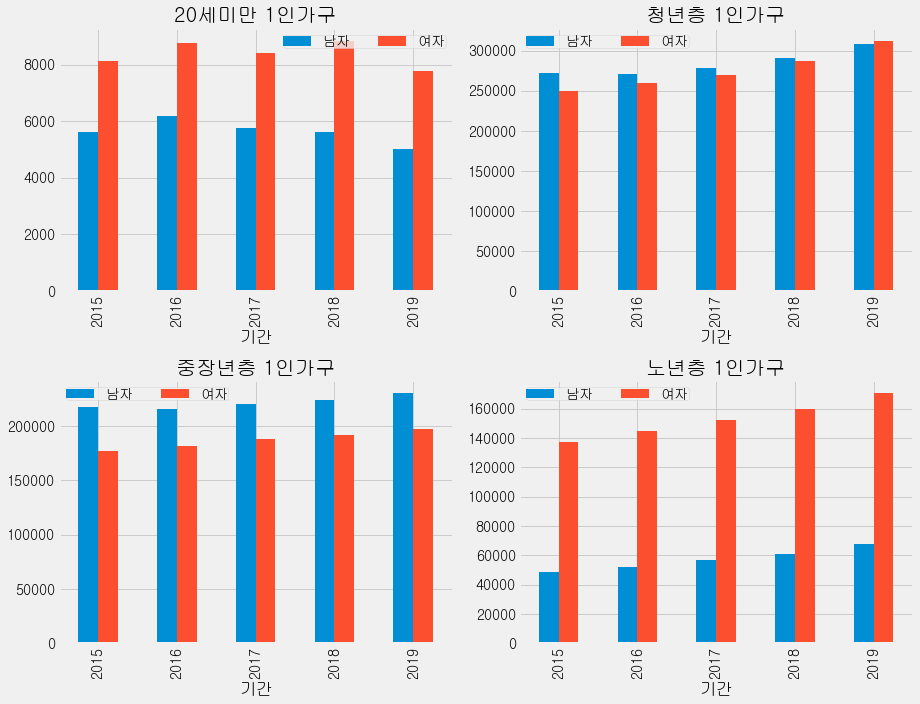

In [36]:
# 1인가구 연령층별 남녀비율
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

plot1 = data_p_1_sex.set_index('기간').pivot(columns='성별').plot(kind='bar', y='20세미만', ax=axes[0,0],
                                                      figsize=(13,10), title='20세미만 1인가구')
axes[0,0].legend(ncol=2, loc='best',borderpad=0)

plot2 = data_p_1_sex.set_index('기간').pivot(columns='성별').plot(kind='bar', y='청년층', ax=axes[0,1], title='청년층 1인가구')
axes[0,1].legend(ncol=2, loc='best',borderpad=0)

plot3 = data_p_1_sex.set_index('기간').pivot(columns='성별').plot(kind='bar', y='중장년층', ax=axes[1,0], title='중장년층 1인가구')
axes[1,0].legend(ncol=2, loc='best',borderpad=0)

plot4 = data_p_1_sex.set_index('기간').pivot(columns='성별').plot(kind='bar', y='노년층', ax=axes[1,1], title='노년층 1인가구')
axes[1,1].legend(ncol=2, loc='best',borderpad=0)

plt.tight_layout()
plt.show()

전체 1인가구에서 여성1인가구의 비중이 더 높지만, 특히나 20세미만과 노년층에서 여성1인가구의 비중이 높게 나타난다.   
노년층에서의 이러한 현상은 여성의 기대수명이 더 높기 때문이 아닐까 생각한다.

In [37]:
data_p_1 = data_p_1[(data_p_1['자치구']!='합계') & (data_p_1['성별']=='계')]
data_p_1

기간  자치구 성별      합계  20세미만    청년층   중장년층    노년층
3    2015  종로구  계   22776    396  10582   7816   3982
6    2015   중구  계   19161    282   7801   7490   3588
9    2015  용산구  계   31025    212  13601  11617   5595
12   2015  성동구  계   35259    634  16268  12730   5627
15   2015  광진구  계   54210    787  30365  17045   6013
..    ...  ... ..     ...    ...    ...    ...    ...
375  2019  관악구  계  119863   1023  78877  27463  12500
378  2019  서초구  계   42667    521  21277  14592   6277
381  2019  강남구  계   66073    607  34841  21135   9490
384  2019  송파구  계   68861    282  33281  24170  11128
387  2019  강동구  계   45188    157  17219  18289   9523

[125 rows x 8 columns]

In [38]:
data_p_1_2015 = data_p_1[data_p_1['기간']==2015]
data_p_1_2016 = data_p_1[data_p_1['기간']==2016]
data_p_1_2017 = data_p_1[data_p_1['기간']==2017]
data_p_1_2018 = data_p_1[data_p_1['기간']==2018]
data_p_1_2019 = data_p_1[data_p_1['기간']==2019]

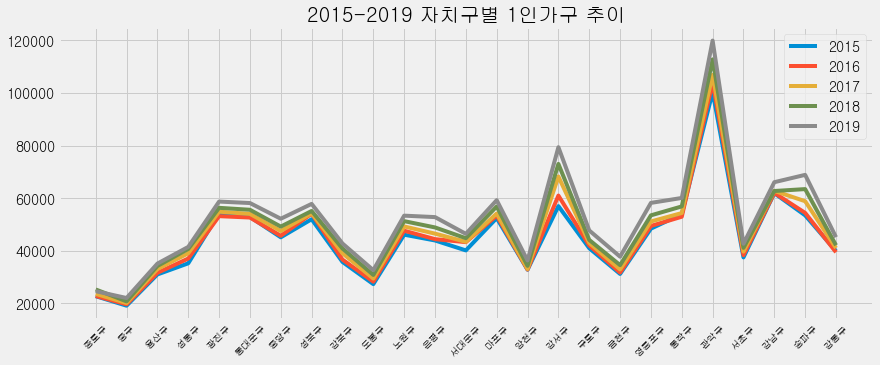

In [39]:
# 자치구별 1인가구 현황
plt.figure(figsize=(13,5))
plt.title('2015-2019 자치구별 1인가구 추이')
plt.xticks(rotation=45, size=10)
plt.plot(data_p_1_2015['자치구'], data_p_1_2015['합계'], label='2015')
plt.plot(data_p_1_2016['자치구'], data_p_1_2016['합계'], label='2016')
plt.plot(data_p_1_2017['자치구'], data_p_1_2017['합계'], label='2017')
plt.plot(data_p_1_2018['자치구'], data_p_1_2018['합계'], label='2018')
plt.plot(data_p_1_2019['자치구'], data_p_1_2019['합계'], label='2019')
plt.legend()
plt.show()

1인가구는 매년 증가 추세이지만 자치구별 추이에는 큰 차이가 없다.   
5년간 가장 많이 증가한 곳은 강서구와 송파구로 보인다.

In [40]:
# 2019 자치구별 1인가구 합계
p1_map = folium.Map(location=[37.5502,126.982], zoom_start=10.5, tiles='cartodbpositron',scrollWheelZoom=False)
choropleth = folium.Choropleth(geo_data=gu, key_on='properties.sig_kor_nm', data=data_p_1_2019, columns=['자치구','합계'],legend_name='2019 서울시 1인가구 현황').add_to(p1_map)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['sig_kor_nm']))
p1_map

## 서울 전체 인구

In [41]:
# 2014~2019
data_p_seoul2.head()

기간 행정구역별     구분           계     0~4세     5~9세   10~14세   15~19세   20~24세  \
0  2014    합계      계  10,369,593  411,132  393,451  459,224  594,242  727,181   
1  2014    합계    한국인  10,103,233  404,369  389,623  456,867  587,646  701,179   
2  2014    합계  등록외국인     266,360    6,763    3,828    2,357    6,596   26,002   
3  2014   종로구      계     165,344    4,609    4,991    6,704    9,372   12,979   
4  2014   종로구    한국인     156,993    4,445    4,886    6,622    9,004   11,384   

    25~29세  ...   55~59세   60~64세   65~69세   70~74세   75~79세   80~84세  85~89세  \
0  793,943  ...  801,260  552,102  439,917  345,255  225,363  119,127  58,767   
1  756,772  ...  773,183  542,953  437,267  344,188  224,660  118,754  58,585   
2   37,171  ...   28,077    9,149    2,650    1,067      703      373     182   
3   13,283  ...   12,965    8,988    7,748    6,956    4,814    2,663   1,370   
4   11,937  ...   12,301    8,775    7,665    6,919    4,798    2,646   1,365   

   90~94세 95~99세 100세 이상  
0  22,532  5,967   4,688  
1  22,462  5,942   4,671  
2      70     25      17  
3     606    183     197  
4     605    182     196  

[5 rows x 25 columns]

In [42]:
# 2020
data_p_seoul3.head()

시점 행정구역(시군구)별  성별          계    0 - 4세    5 - 9세  10 - 14세  15 - 19세  \
0  2020      서울특별시   계  9533412.0  285507.0  356875.5  369850.5  427350.0   
1  2020      서울특별시  남자  4642652.5  146911.5  182973.5  190280.5  219320.5   
2  2020      서울특별시  여자  4890759.5  138595.5  173902.0  179570.0  208029.5   
3  2020     　　　종로구   계   144865.5    3309.0    4548.5    5120.0    6181.5   
4  2020     　　　종로구  남자    70612.5    1668.0    2296.5    2575.0    3098.5   

   20 - 24세  25 - 29세  ...  65 - 69세  70 - 74세  75 - 79세    80세 이상  80 - 84세  \
0  631877.5  816546.0  ...  496050.0  385833.5  289716.5  297315.5  178205.5   
1  303775.5  402080.5  ...  233225.0  177616.0  130497.5  108656.5   72557.5   
2  328102.0  414465.5  ...  262825.0  208217.5  159219.0  188659.0  105648.0   
3   10602.0   12667.5  ...    7636.5    6244.5    5449.5    6264.5    3682.0   
4    4975.5    6526.0  ...    3743.5    2842.0    2368.5    2405.5    1517.0   

     85세 이상  85 - 89세  90 - 94세  95 - 99세  100세 이상  
0  119110.0   81871.5   29509.5    6768.5    960.5  
1   36099.0   26993.0    7378.5    1550.0    177.5  
2   83011.0   54878.5   22131.0    5218.5    783.0  
3    2582.5    1748.5     639.0     169.0     26.0  
4     888.5     642.0     188.5      52.0      6.0  

[5 rows x 27 columns]

In [43]:
# 자치구 칼럼명 통일
data_p_seoul2.rename(columns={'행정구역별': '자치구'}, inplace=True)
data_p_seoul3.rename(columns={'행정구역(시군구)별': '자치구'}, inplace=True)

In [44]:
data_p_seoul2 = data_p_seoul2[data_p_seoul2['구분']=='한국인']

In [45]:
data_p_seoul3 = data_p_seoul3[data_p_seoul3['성별']=='계']

In [46]:
# int형 변환
data_p_seoul2.iloc[:,3:] = data_p_seoul2.iloc[:,3:].replace(',','',regex=True).astype(int)
data_p_seoul3.iloc[:,3:] = data_p_seoul3.iloc[:,3:].replace(',','',regex=True).astype(int)

연령대 기준 = 20-39:청년층, 40-64:중장년층, 65세 이상:노년층

In [47]:
# 2014~2019 데이터 연령대별 데이터 통합
data_p_seoul2['20세미만'] = data_p_seoul2.iloc[:,4:8].sum(axis=1)
data_p_seoul2['청년층'] = data_p_seoul2.iloc[:,8:12].sum(axis=1)
data_p_seoul2['중장년층'] = data_p_seoul2.iloc[:,12:17].sum(axis=1)
data_p_seoul2['노년층'] = data_p_seoul2.iloc[:,17:25].sum(axis=1)

data_p_seoul2.drop(data_p_seoul2.iloc[:,4:25], axis=1, inplace=True)
data_p_seoul2

기간  자치구   구분         계    20세미만      청년층     중장년층      노년층
1    2014   합계  한국인  10103233  1838505  3171617  3876582  1216529
4    2014  종로구  한국인    156993    24957    45737    61923    24376
7    2014   중구  한국인    128065    18358    39087    50880    19740
10   2014  용산구  한국인    235951    38310    72219    90851    34571
13   2014  성동구  한국인    296086    50574    95248   113700    36564
..    ...  ...  ...       ...      ...      ...      ...      ...
454  2019  관악구  한국인    500094    55797   196245   173265    74787
457  2019  서초구  한국인    430826    81964   123233   168593    57036
460  2019  강남구  한국인    545169    99155   161589   213529    70896
463  2019  송파구  한국인    675961   115307   210536   262936    87182
466  2019  강동구  한국인    436067    70623   126748   175355    63341

[156 rows x 8 columns]

In [48]:
data_p_seoul2.drop('구분', axis=1, inplace=True)
data_p_seoul2

기간  자치구         계    20세미만      청년층     중장년층      노년층
1    2014   합계  10103233  1838505  3171617  3876582  1216529
4    2014  종로구    156993    24957    45737    61923    24376
7    2014   중구    128065    18358    39087    50880    19740
10   2014  용산구    235951    38310    72219    90851    34571
13   2014  성동구    296086    50574    95248   113700    36564
..    ...  ...       ...      ...      ...      ...      ...
454  2019  관악구    500094    55797   196245   173265    74787
457  2019  서초구    430826    81964   123233   168593    57036
460  2019  강남구    545169    99155   161589   213529    70896
463  2019  송파구    675961   115307   210536   262936    87182
466  2019  강동구    436067    70623   126748   175355    63341

[156 rows x 7 columns]

In [49]:
# 2020 데이터 연령대별 데이터 통합
data_p_seoul3.drop(['80세 이상','85세 이상'], axis=1, inplace=True)
data_p_seoul3['20세미만'] = data_p_seoul3.iloc[:,4:8].sum(axis=1)
data_p_seoul3['청년층'] = data_p_seoul3.iloc[:,8:12].sum(axis=1)
data_p_seoul3['중장년층'] = data_p_seoul3.iloc[:,12:17].sum(axis=1)
data_p_seoul3['노년층'] = data_p_seoul3.iloc[:,17:25].sum(axis=1)

data_p_seoul3.drop(data_p_seoul3.iloc[:,4:25], axis=1, inplace=True)
data_p_seoul3

시점      자치구 성별        계    20세미만      청년층     중장년층      노년층
0   2020    서울특별시  계  9533412  1439582  2924737  3700175  1468912
3   2020   　　　종로구  계   144865    19158    43059    57050    25593
6   2020    　　　중구  계   121519    14054    38455    47132    21875
9   2020   　　　용산구  계   219403    29579    70032    84617    35172
12  2020   　　　성동구  계   291841    41715    94647   112545    42929
15  2020   　　　광진구  계   343783    47253   118569   130532    47424
18  2020  　　　동대문구  계   337801    45751   105549   128370    58126
21  2020   　　　중랑구  계   390233    51424   114132   159037    65634
24  2020   　　　성북구  계   432206    67861   126467   168362    69510
27  2020   　　　강북구  계   305511    39298    82269   123850    60090
30  2020   　　　도봉구  계   325050    46265    85629   133994    59156
33  2020   　　　노원구  계   522235    89302   138918   212425    81586
36  2020   　　　은평구  계   471906    70214   134475   187216    79995
39  2020  　　　서대문구  계   304074    44250    93507   115866    50445
42  2020   　　　마포구  계   365392    54538   125015   135184    50649
45  2020   　　　양천구  계   450971    83896   118256   186816    61999
48  2020   　　　강서구  계   579138    87642   187061   219976    84454
51  2020   　　　구로구  계   400914    60097   118713   156295    65805
54  2020   　　　금천구  계   228342    28293    71698    91221    37124
57  2020  　　　영등포구  계   366258    50062   124512   135384    56294
60  2020   　　　동작구  계   387858    54092   128782   143476    61503
63  2020   　　　관악구  계   489798    53220   194638   167518    74418
66  2020   　　　서초구  계   419614    80300   119305   163803    56201
69  2020   　　　강남구  계   530126    97002   156051   207063    70005
72  2020   　　　송파구  계   662838   112291   205914   256767    87859
75  2020   　　　강동구  계   441732    72003   129059   175643    65022

In [50]:
data_p_seoul3.drop('성별', axis=1, inplace=True)

In [51]:
data_p_seoul3['자치구'][0] = '합계'
data_p_seoul3.rename(columns={'시점': '기간'}, inplace=True)

In [52]:
data_p_seoul = pd.concat([data_p_seoul2, data_p_seoul3], ignore_index=True)

In [53]:
data_p_seoul_sum = data_p_seoul[data_p_seoul['자치구']=='합계']

In [54]:
# 2014~2020 서울 인구 데이터 완성
data_p_seoul = data_p_seoul[data_p_seoul['자치구']!='합계']
data_p_seoul

기간     자치구       계   20세미만     청년층    중장년층    노년층
1    2014     종로구  156993   24957   45737   61923  24376
2    2014      중구  128065   18358   39087   50880  19740
3    2014     용산구  235951   38310   72219   90851  34571
4    2014     성동구  296086   50574   95248  113700  36564
5    2014     광진구  363354   63127  123893  137526  38808
..    ...     ...     ...     ...     ...     ...    ...
177  2020  　　　관악구  489798   53220  194638  167518  74418
178  2020  　　　서초구  419614   80300  119305  163803  56201
179  2020  　　　강남구  530126   97002  156051  207063  70005
180  2020  　　　송파구  662838  112291  205914  256767  87859
181  2020  　　　강동구  441732   72003  129059  175643  65022

[175 rows x 7 columns]

In [55]:
data_p_2020 = data_p_seoul[data_p_seoul['기간']==2020]

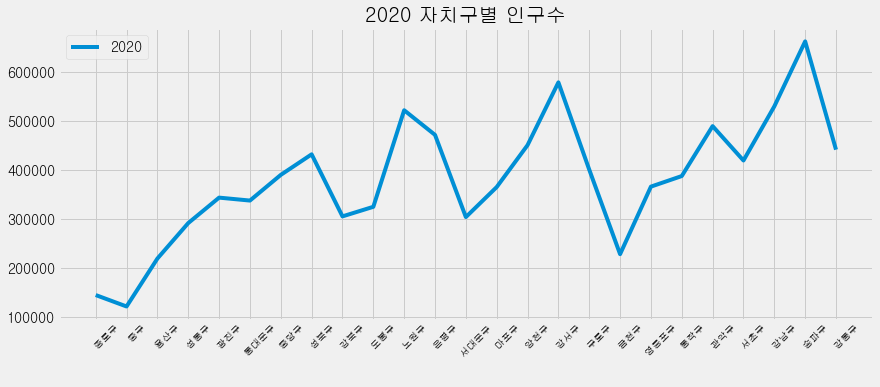

In [56]:
# 2020 자치구 인구수
plt.figure(figsize=(13,5))
plt.title('2020 자치구별 인구수')
plt.xticks(rotation=45, size=10)
plt.plot(data_p_2020['자치구'], data_p_2020['계'], label='2020')
plt.legend()
plt.show()

In [57]:
# 자치구별 1인가구 비율
ratio = pd.DataFrame(columns=['자치구'])
ratio['자치구'] = data_p_2020['자치구'].values
for i in data_p_1['기간']:
    ratio[i] = (data_p_1[data_p_1['기간']==i]['합계'].values/data_p_seoul[data_p_seoul['기간']==i]['계'].values)*100
ratio

자치구       2015       2016       2017       2018       2019
0    　　　종로구  14.695521  14.950536  15.272986  16.545912  16.307092
1     　　　중구  15.239436  15.705515  16.040220  16.546431  17.498474
2    　　　용산구  13.295935  13.742557  14.433521  14.952030  15.370621
3    　　　성동구  11.871597  12.388600  12.816921  13.206757  13.788473
4    　　　광진구  15.042914  14.884313  15.338423  15.844628  16.710972
5   　　　동대문구  14.683759  14.828104  15.408659  15.972613  16.797518
6    　　　중랑구  10.905296  11.123222  11.646245  12.203845  13.147110
7    　　　성북구  11.323281  12.016520  12.215379  12.649701  13.064950
8    　　　강북구  10.815932  11.206773  12.044539  12.805956  13.629704
9    　　　도봉구   7.786085   8.125897   8.562438   9.088632   9.795058
10   　　　노원구   8.028257   8.393692   8.886135   9.430770  10.013980
11   　　　은평구   8.823907   9.042151   9.559485  10.117612  11.002183
12  　　　서대문구  12.865980  13.780658  13.880435  14.435425  15.012751
13   　　　마포구  13.527137  14.051888  14.446475  15.153422  15.840229
14   　　　양천구   6.776023   6.882000   7.022757   7.390157   7.932732
15   　　　강서구   9.674506  10.241736  11.340871  12.230693  13.411885
16   　　　구로구   9.710679  10.071824  10.464963  10.915038  11.739421
17   　　　금천구  13.212490  13.479136  14.002739  14.776181  16.226966
18  　　　영등포구  12.795902  13.343569  13.878985  14.540565  15.832876
19   　　　동작구  13.466919  13.205585  13.718493  14.354258  15.175155
20   　　　관악구  19.680063  20.513326  21.232990  22.458697  23.968094
21   　　　서초구   8.392798   8.577300   9.000639   9.479642   9.903534
22   　　　강남구  10.736780  10.932174  11.286959  11.565480  12.119728
23   　　　송파구   8.099476   8.270969   8.856035   9.518102  10.187126
24   　　　강동구   8.698638   8.886052   9.410325   9.852353  10.362628

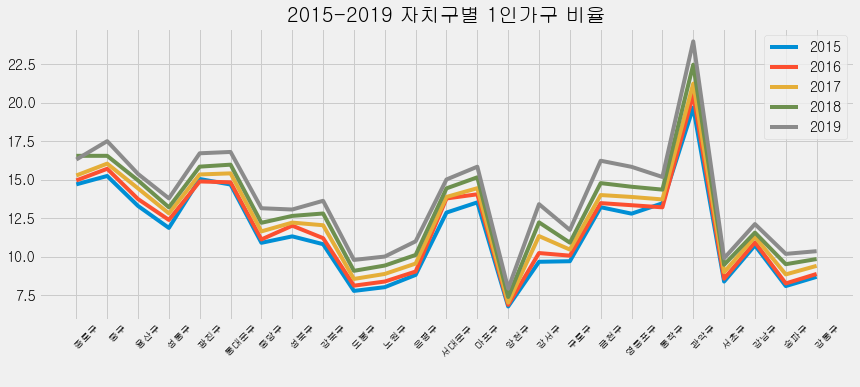

In [58]:
# 자치구별 1인가구 비율
plt.figure(figsize=(13,5))
plt.title('2015-2019 자치구별 1인가구 비율')
plt.xticks(rotation=45, size=10)
plt.plot(ratio['자치구'], ratio[2015], label='2015')
plt.plot(ratio['자치구'], ratio[2016], label='2016')
plt.plot(ratio['자치구'], ratio[2017], label='2017')
plt.plot(ratio['자치구'], ratio[2018], label='2018')
plt.plot(ratio['자치구'], ratio[2019], label='2019')
plt.legend()
plt.show()

1인가구 비율은 종로구 제외 모두 증가했다. 그중 작년대비 증가폭이 가장 큰 곳은 금천구로 보인다.

# 데이터 확인

## 소음

In [59]:
data_noise.head()

기간   지역 환경관련 전체민원 소음진동 민원 분야별 소음진동민원             
     기간   지역 환경관련 전체민원 소음진동 민원         공장   교통      생활
0  2010   합계    35,010  23,396         52  261  23,083
1  2010  종로구       979     635          -    -     635
2  2010   중구     1,083     537          -    -     537
3  2010  용산구       703     383          -    5     378
4  2010  성동구     1,536   1,123          -    1   1,122

In [60]:
data_noise.columns = ['기간','자치구','환경관련 전체민원', '소음진동 민원','공장','교통','생활']

In [61]:
# 데이터 타입 확인
data_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   기간         234 non-null    int64 
 1   자치구        234 non-null    object
 2   환경관련 전체민원  234 non-null    object
 3   소음진동 민원    234 non-null    object
 4   공장         234 non-null    object
 5   교통         234 non-null    object
 6   생활         234 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB


In [62]:
# object -> int 변환
data_noise['환경관련 전체민원'] = data_noise['환경관련 전체민원'].replace(',','', regex=True).astype(int)
data_noise['소음진동 민원'] = data_noise['소음진동 민원'].replace(',','', regex=True).astype(int)
data_noise['공장'] = data_noise['공장'].replace('-','0', regex=True).astype(int)
data_noise['교통'] = data_noise['교통'].replace(',','', regex=True).replace('-','0', regex=True).astype(int)
data_noise['생활'] = data_noise['생활'].replace(',','', regex=True).astype(int)

In [63]:
# 연도별 합계
data_noise[data_noise['자치구']=='합계']

기간 자치구  환경관련 전체민원  소음진동 민원  공장    교통     생활
0    2010  합계      35010    23396  52   261  23083
26   2011  합계      38212    21745  62   164  21519
52   2012  합계      36770    20166  18    83  20065
78   2013  합계      45333    27558  18   105  27435
104  2014  합계      44860    31275  27   193  31055
130  2015  합계      55405    41286  36   187  41063
156  2016  합계      67931    52557  17  1673  50867
182  2017  합계      68527    55743  24   973  54746
208  2018  합계      65002    52173  17   868  51288

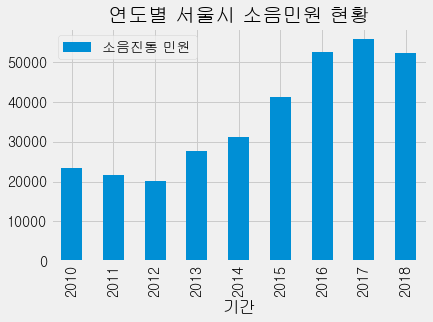

In [64]:
# 연도별 서울시 소음민원 합계
data_noise[data_noise['자치구']=='합계'].plot(kind='bar',title="연도별 서울시 소음민원 현황", x='기간', y='소음진동 민원')
plt.show()

소음민원 건수는 연간 증가 추세를 보인다.

In [65]:
# 합계를 제외한 데이터
data_noise_n = data_noise[data_noise['자치구']!='합계']

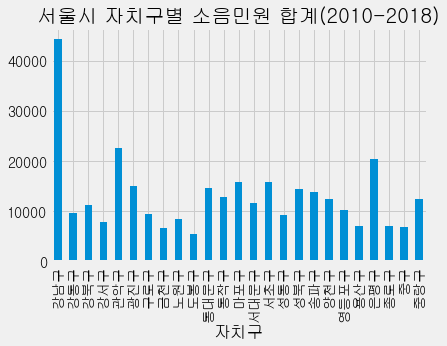

In [66]:
data_noise_n.groupby('자치구')['소음진동 민원'].sum().plot(kind='bar',title="서울시 자치구별 소음민원 합계(2010-2018)")
plt.show()

자치구별 9년간(2010-2018)의 소음민원 합계를 보면 강남구가 독보적으로 높다.

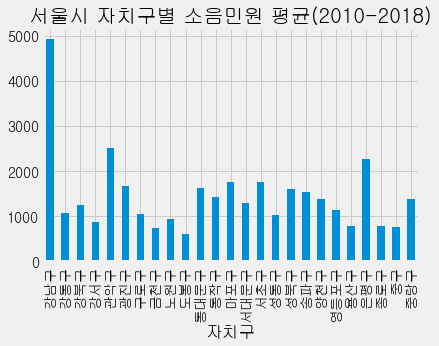

In [67]:
# 자치구별 9년간 소음민원 평균값
data_noise_mean = data_noise_n.groupby('자치구')['소음진동 민원'].mean()
data_noise_mean.plot(kind='bar', title='서울시 자치구별 소음민원 평균(2010-2018)')
plt.show()

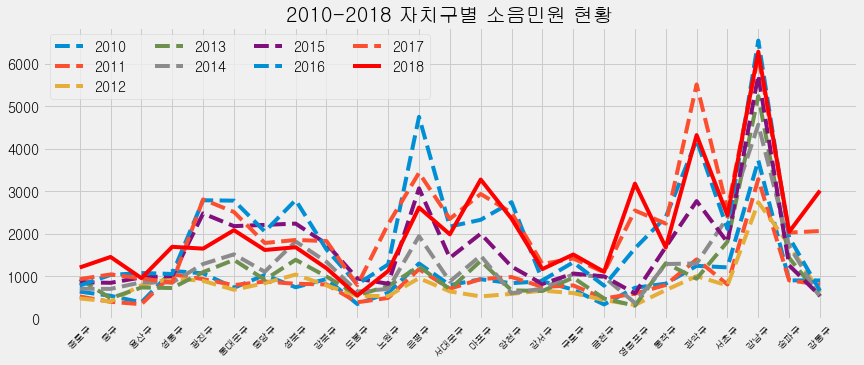

In [68]:
# 연간 자치구별 민원 변화
plt.figure(figsize=(13,5))
plt.title('2010-2018 자치구별 소음민원 현황')
plt.xticks(rotation=45, size=10)

for i in data_noise_n['기간'].unique():
    if i == 2018:
        style = 'r'
    else:
        style = '--'
    plt.plot(data_noise_n[data_noise_n['기간']==i]['자치구'], data_noise_n[data_noise_n['기간']==i]['소음진동 민원'], style , label=i)

plt.legend(ncol=4, loc='best')
plt.show()

연도별 소음민원 건수의 변화를 보면, 가장 최신 데이터인 2018년의 빨간 실선을 기준으로 민원이 가장 많은 강남구는 계속해서 민원이 증가해온 것을 볼 수 있고, 은평구와 성북구, 광진구, 관악구 등은 민원 건수가 줄어든 것을 확인할 수 있다.

In [69]:
# 소음민원 평균 지도 시각화
noise_map = folium.Map(location=[37.5502,126.982], zoom_start=10.5, tiles='cartodbpositron',scrollWheelZoom=False)
choropleth = folium.Choropleth(geo_data=gu, key_on='properties.sig_kor_nm', data=data_noise_mean, columns=['자치구'],legend_name='2010-2018 서울시 소음민원 평균(건)').add_to(noise_map)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['sig_kor_nm']))
noise_map

## 의료시설

- ### 응급실

In [70]:
data_emergency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기관ID        60 non-null     object 
 1   주소          60 non-null     object 
 2   병원분류        60 non-null     object 
 3   병원분류명       60 non-null     object 
 4   응급의료기관코드    60 non-null     object 
 5   응급의료기관코드명   60 non-null     object 
 6   응급실운영여부     60 non-null     int64  
 7   비고          60 non-null     object 
 8   기관설명상세      60 non-null     object 
 9   간이약도        60 non-null     object 
 10  기관명         60 non-null     object 
 11  대표전화1       60 non-null     object 
 12  응급실전화       60 non-null     object 
 13  진료시간(월요일)C  60 non-null     int64  
 14  진료시간(화요일)C  60 non-null     int64  
 15  진료시간(수요일)C  60 non-null     int64  
 16  진료시간(목요일)C  60 non-null     int64  
 17  진료시간(금요일)C  60 non-null     int64  
 18  진료시간(토요일)C  60 non-null     int64  
 19  진료시간(일요일)C  60 non-null     int

In [71]:
# 불필요한 열 삭제
data_emergency = data_emergency.drop(columns=['대표전화1','응급실전화','진료시간(월요일)C','진료시간(화요일)C','진료시간(수요일)C','진료시간(목요일)C','진료시간(금요일)C','진료시간(토요일)C','진료시간(일요일)C','진료시간(공휴일)C','진료시간(월요일)S','진료시간(화요일)S','진료시간(수요일)S','진료시간(목요일)S','진료시간(금요일)S','진료시간(토요일)S','진료시간(일요일)S','진료시간(공휴일)S','우편번호1','우편번호2','작업시간','병원분류','응급의료기관코드','응급실운영여부','비고','기관설명상세','간이약도'])

In [72]:
data_emergency.head(2)

기관ID                               주소 병원분류명 응급의료기관코드명  \
0  A1100008  서울특별시 성북구 고려대로 73 고려대병원 (안암동5가)  종합병원  권역응급의료센터   
1  A1121013         서울특별시 은평구 통일로 1021 (진관동)  종합병원  지역응급의료센터   

                      기관명        병원경도       병원위도  
0  (학)고려대학교의과대학부속병원(안암병원)  127.026471  37.587156  
1           가톨릭대학교 은평성모병원  126.916150  37.633608

In [73]:
# 주소칼럼 데이터로 자치구 칼럼 생성하고 주소칼럼 삭제
for i in range(len(자치구)):
    data_emergency.loc[data_emergency['주소'].str.contains(자치구[i]), '자치구'] = 자치구[i]
data_emergency = data_emergency.drop(columns='주소')

In [74]:
data_emergency.head(3)

기관ID 병원분류명  응급의료기관코드명                     기관명        병원경도       병원위도  \
0  A1100008  종합병원   권역응급의료센터  (학)고려대학교의과대학부속병원(안암병원)  127.026471  37.587156   
1  A1121013  종합병원   지역응급의료센터           가톨릭대학교 은평성모병원  126.916150  37.633608   
2  A1100047    병원  응급실운영신고기관                  강남고려병원  126.956781  37.485618   

   자치구  
0  성북구  
1  은평구  
2  관악구

In [75]:
data_emergency['자치구'].value_counts()

영등포구    8
강남구     4
관악구     4
강서구     4
동대문구    3
강동구     3
은평구     3
종로구     3
양천구     3
노원구     3
중랑구     2
중구      2
광진구     2
강북구     2
서대문구    2
동작구     2
구로구     2
송파구     2
금천구     1
성북구     1
성동구     1
마포구     1
용산구     1
서초구     1
Name: 자치구, dtype: int64

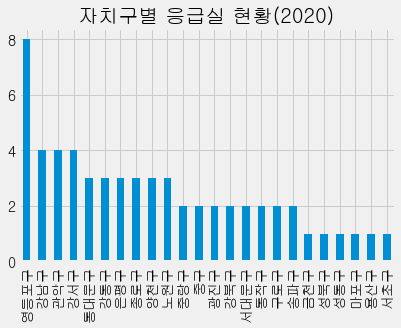

In [76]:
data_emergency['자치구'].value_counts().plot(kind="bar", title="자치구별 응급실 현황(2020)")
plt.show()

- ### 의료기관

In [77]:
data_hospital.head()

기간  자치구       계         종합병원           병원             의원          ...  \
     기간  자치구     병원수     병상수  병원수     병상수  병원수     병상수    병원수     병상수  ...   
0  2010  서울시  15,621  75,984   58  32,197  165  13,348  7,355  15,190  ...   
1  2010  종로구     474   3,284    4   2,931    2      60    163     182  ...   
2  2010   중구     542   1,730    3   1,260    2     212    195     200  ...   
3  2010  용산구     292   1,454    3   1,191    1     100    118     107  ...   
4  2010  성동구     352   1,978    1     839    6     540    161     298  ...   

  치과병원        치과의원     한방병원          한방의원      조산원      
   병원수  병상수    병원수 병상수  병원수    병상수    병원수  병상수 병원수 병상수  
0   71  103  4,468  26   30  1,827  3,342  214   4   9  
1    2   40    165   -    1     31    130    -   -   -  
2    6    -    221   -    -      -     97    -   -   -  
3    -    -    106   -    1     56     62    -   -   -  
4    1    -    111   -    1     72     69    -   -   -  

[5 rows x 30 columns]

In [78]:
data_hospital.columns = ['기간','자치구','병원수','병상수','종합병원_수','종합병원_병상수','병원_수','병원_병상수','의원_수','의원_병상수','부속병의원_수','부속병의원_병상수','요양병원_수','요양병원_병상수','노인전문병원_수','노인전문병원_병상수','결핵병원_수','결핵병원_병상수','정신병원_수','정신병원_병상수','치과병원_수','치과병원_병상수','치과의원_수','치과의원_병상수','한방병원_수','한방병원_병상수','한방의원_수','한방의원_병상수','조산원_수','조산원_병상수']
data_hospital.head(2)

기간  자치구     병원수     병상수 종합병원_수 종합병원_병상수  병원_수  병원_병상수   의원_수  의원_병상수  \
0  2010  서울시  15,621  75,984     58   32,197   165  13,348  7,355  15,190   
1  2010  종로구     474   3,284      4    2,931     2      60    163     182   

   ... 치과병원_수 치과병원_병상수 치과의원_수 치과의원_병상수 한방병원_수 한방병원_병상수 한방의원_수 한방의원_병상수 조산원_수  \
0  ...     71      103  4,468       26     30    1,827  3,342      214     4   
1  ...      2       40    165        -      1       31    130        -     -   

  조산원_병상수  
0       9  
1       -  

[2 rows x 30 columns]

In [79]:
data_hospital = data_hospital.drop(columns = data_hospital.columns[data_hospital.columns.str.contains('병상')], axis=1)
data_hospital.head(2)

기간  자치구     병원수 종합병원_수  병원_수   의원_수 부속병의원_수 요양병원_수 노인전문병원_수 결핵병원_수  \
0  2010  서울시  15,621     58   165  7,355      46     66       10      1   
1  2010  종로구     474      4     2    163       6      1        -      -   

  정신병원_수 치과병원_수 치과의원_수 한방병원_수 한방의원_수 조산원_수  
0      5     71  4,468     30  3,342     4  
1      -      2    165      1    130     -

In [80]:
# 데이터 통합용 데이터 프레임 생성
data_med = data_hospital[['기간','자치구','병원수']]
data_med = data_med[data_med['자치구']!='서울시']
data_med

기간  자치구    병원수
1    2010  종로구    474
2    2010   중구    542
3    2010  용산구    292
4    2010  성동구    352
5    2010  광진구    501
..    ...  ...    ...
255  2019  관악구    693
256  2019  서초구  1,226
257  2019  강남구  2,643
258  2019  송파구  1,165
259  2019  강동구    789

[250 rows x 3 columns]

In [81]:
# 응급실 데이터
data_emergency_n = pd.DataFrame(data_emergency['자치구'].value_counts())
data_emergency_n.columns = ['응급실']
data_emergency_n

응급실
영등포구    8
강남구     4
관악구     4
강서구     4
동대문구    3
강동구     3
은평구     3
종로구     3
양천구     3
노원구     3
중랑구     2
중구      2
광진구     2
강북구     2
서대문구    2
동작구     2
구로구     2
송파구     2
금천구     1
성북구     1
성동구     1
마포구     1
용산구     1
서초구     1

In [82]:
data_emergency_n = data_emergency_n.reset_index()
data_emergency_n.rename(columns={'index': '자치구'}, inplace=True)

In [83]:
for i in range(len(data_emergency_n)):
    data_med.loc[(data_med['기간']==2019)&(data_med['자치구']==data_emergency_n['자치구'][i]), '응급실'] = data_emergency_n['응급실'][i]

In [84]:
data_med

기간  자치구    병원수  응급실
1    2010  종로구    474  NaN
2    2010   중구    542  NaN
3    2010  용산구    292  NaN
4    2010  성동구    352  NaN
5    2010  광진구    501  NaN
..    ...  ...    ...  ...
255  2019  관악구    693  4.0
256  2019  서초구  1,226  1.0
257  2019  강남구  2,643  4.0
258  2019  송파구  1,165  2.0
259  2019  강동구    789  3.0

[250 rows x 4 columns]

In [85]:
# int로 변환 
data_med['응급실'].replace(np.nan, 0, regex=True, inplace=True)
# 응급실 데이터는 2020년 데이터이나 의료기관데이터에 맞춰 2019년도에 넣음. 이전 연도는 0으로 표시(실제0은 아님)
data_med.iloc[:,2:] = data_med.iloc[:,2:].replace(',','', regex=True).astype(int)
data_med

기간  자치구   병원수  응급실
1    2010  종로구   474    0
2    2010   중구   542    0
3    2010  용산구   292    0
4    2010  성동구   352    0
5    2010  광진구   501    0
..    ...  ...   ...  ...
255  2019  관악구   693    4
256  2019  서초구  1226    1
257  2019  강남구  2643    4
258  2019  송파구  1165    2
259  2019  강동구   789    3

[250 rows x 4 columns]

In [86]:
# 자치구별 의료시설 현황
med_map = folium.Map(location=[37.5502,126.982], zoom_start=10.5, tiles='cartodbpositron',scrollWheelZoom=False)
choropleth = folium.Choropleth(geo_data=gu, key_on='properties.sig_kor_nm', data=data_med[data_med['기간']==2019], columns=['자치구','병원수'],legend_name='의료기관 수').add_to(med_map)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['sig_kor_nm']))
med_map

## 치안 및 방범 

- ### 안전비상벨

In [87]:
data_bell.head(2)

번호    안전비상벨관리번호 설치목적 설치장소유형 설치위치               소재지도로명주소 소재지지번주소  \
1  1  C-JH02-0051  방범용    가로변  가로변   서울특별시 중랑구 중랑역로3가길 31           
2  2  C-JH02-0052  방범용    가로변  가로변  서울특별시 중랑구 봉화산로3길 53-8           

            위도           경도 연계방식 경찰연계유무 경비업체연계유무 관리사무소연계유무 부가기능 안전비상벨설치연도  \
1  37.59630276  127.0748032  단방향      N        N         N           2017   
2  37.60404587   127.075133  단방향      N        N         N           2017   

       최종점검일자 최종점검결과구분       관리기관명      관리기관전화번호     데이터기준일자  
1  2020-03-02        Y  서울특별시 중랑구청  02-2094-0284  2020-03-17  
2  2020-03-02        Y  서울특별시 중랑구청  02-2094-0284  2020-03-17

In [88]:
# 주소칼럼 데이터로 자치구 칼럼 생성하고 주소칼럼 삭제
for i in range(len(자치구)):
    data_bell.loc[data_bell['소재지도로명주소'].str.contains(자치구[i]), '자치구'] = 자치구[i]
data_bell = data_bell.drop(columns='소재지도로명주소')

In [89]:
data_bell = data_bell[['자치구','설치목적','위도','경도']]

In [90]:
data_bell

자치구 설치목적           위도           경도
1      중랑구  방범용  37.59630276  127.0748032
2      중랑구  방범용  37.60404587   127.075133
3      중랑구  방범용  37.59413736  127.0738861
4      중랑구  방범용  37.60848528  127.0786241
5      중랑구  방범용    37.610617  127.0785143
...    ...  ...          ...          ...
15875  금천구  방범용    37.465454   126.892511
15876  금천구  방범용    37.443657   126.904652
15877  금천구  방범용    37.443149   126.904589
15878  금천구  방범용    37.442306   126.904484
15879  금천구  방범용    37.466499   126.891831

[15879 rows x 4 columns]

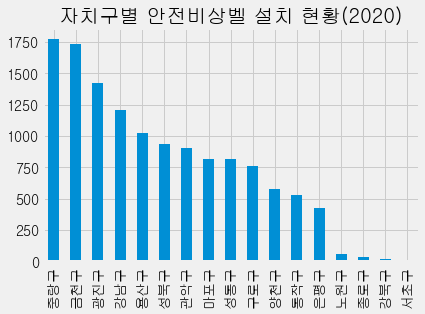

In [91]:
# 자치구별 안전비상벨 설치 현황
data_bell['자치구'].value_counts().plot(kind='bar', title="자치구별 안전비상벨 설치 현황(2020)")
plt.show()

25개 자치구 중 17개 자치구 데이터만 존재함

- ### CCTV

In [92]:
data_cctv

기관명     소계    방범용  도시공원, 놀이터  어린이 보호  쓰레기 무단투기   기타
0    강남구  4,758  3,297        385     567         0  509
1    강동구  1,493    810         96     164        27  396
2    강북구    946    633         94     114         0  105
3    강서구  1,202    807         78     228        28   61
4    관악구  3,223  1,998        204     279       130  612
5    광진구  1,228    894         34     162        72   66
6    구로구  2,746  1,601        308     445        29  363
7    금천구  1,526    790        152     207        32  345
8    노원구  1,576    871        246     178       126  155
9    도봉구    899    358         98      94        61  288
10  동대문구  1,555    992        100     311        19  133
11   동작구  1,792  1,255        103     188         0  246
12   마포구  1,743  1,077         99     134         0  433
13  서대문구  2,705  1,865         88     216         0  536
14   서초구  1,868  1,045        343     137         0  343
15   성동구  2,554  1,544         94     381        77  458
16   성북구  2,221  1,401        100     350       106  264
17   송파구  1,203    549        156     173        19  306
18   양천구  2,498  1,491        113     755         8  131
19  영등포구  1,839    964        107     168        49  551
20   용산구  2,379  1,522        120     179         0  558
21   은평구  2,505  1,475        226     607         3  194
22   종로구  1,925  1,145         85      38         0  657
23    중구  1,260    604        133      51        60  412
24   중랑구  1,053    657         75      55         9  257

In [93]:
data_cctv = data_cctv[['기관명','방범용']]
data_cctv.rename(columns={'기관명': '자치구'}, inplace=True)
data_cctv

자치구    방범용
0    강남구  3,297
1    강동구    810
2    강북구    633
3    강서구    807
4    관악구  1,998
5    광진구    894
6    구로구  1,601
7    금천구    790
8    노원구    871
9    도봉구    358
10  동대문구    992
11   동작구  1,255
12   마포구  1,077
13  서대문구  1,865
14   서초구  1,045
15   성동구  1,544
16   성북구  1,401
17   송파구    549
18   양천구  1,491
19  영등포구    964
20   용산구  1,522
21   은평구  1,475
22   종로구  1,145
23    중구    604
24   중랑구    657

In [94]:
# int 변환
data_cctv['방범용'] = data_cctv['방범용'].replace(',','', regex=True).astype(int)

In [99]:
data_cctv.drop('index', axis=1, inplace=True)

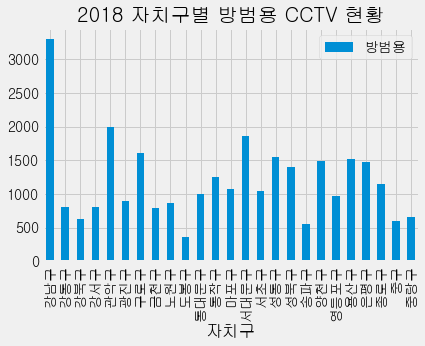

In [100]:
data_cctv.plot(x='자치구',y='방범용' ,kind='bar', title='2018 자치구별 방범용 CCTV 현황')
plt.show()

In [101]:
data_security = data_cctv
data_bell_n = data_bell['자치구'].value_counts()
data_bell_n = data_bell_n.reset_index()
data_bell_n.rename(columns={'index': '자치구', '자치구':'안전비상벨'}, inplace=True)

In [102]:
# 주제 데이터 통합
for i in range(len(data_bell_n)):
    data_security.loc[data_cctv['자치구']==data_bell_n['자치구'][i], '안전비상벨'] = data_bell_n['안전비상벨'][i]
data_security

자치구   방범용   안전비상벨
0    강남구  3297  1207.0
1    강동구   810     NaN
2    강북구   633    22.0
3    강서구   807     NaN
4    관악구  1998   907.0
5    광진구   894  1424.0
6    구로구  1601   760.0
7    금천구   790  1735.0
8    노원구   871    60.0
9    도봉구   358     NaN
10  동대문구   992     NaN
11   동작구  1255   526.0
12   마포구  1077   818.0
13  서대문구  1865     NaN
14   서초구  1045     9.0
15   성동구  1544   813.0
16   성북구  1401   939.0
17   송파구   549     NaN
18   양천구  1491   579.0
19  영등포구   964     NaN
20   용산구  1522  1022.0
21   은평구  1475   423.0
22   종로구  1145    36.0
23    중구   604     NaN
24   중랑구   657  1772.0